# 1) 데이터 준비와 확인

In [1434]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [1435]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #중복제거
    train_data = train_data.dropna(how = 'any') #NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    #텍스트 스트링을 사전 인덱스 스트링으로 변환
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [1436]:
index_to_word = {index:word for word, index in word_to_index.items()}

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 3) 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [1437]:
word_to_index={k:(v+3) for k,v in word_to_index.items()}

word_to_index["<PAD>"]=0
word_to_index["<BOS>"]=1
word_to_index["<UNK>"]=2
word_to_index["<UNUSED>"]=3

index_to_word[0]="<PAD>"
index_to_word[1]="<BOS>"
index_to_word[2]="<UNK>"
index_to_word[3]="<UNUSED>"

In [1438]:
total_data_text=list(X_train)+list(X_test)

num_tokens=[len(tokens) for tokens in total_data_text]
num_tokens=np.array(num_tokens)

print('문장길이 평균:',np.mean(num_tokens))
print('문장길이 최대:',np.max(num_tokens))
print('문장길이 표준편차:',np.std(num_tokens))

max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
maxlen=int(max_tokens)

print('pad_sequences maxlen:',maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장길이 평균: 15.96940191154864
문장길이 최대: 116
문장길이 표준편차: 12.843571191092
pad_sequences maxlen: 41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


In [1439]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델구성 및 validation set 구성
## 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [1440]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수. 

# RNN 모델 사용 (LSTM 사용)
# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.LSTM(8))# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

In [1441]:
# RNN 모델 사용 (GRU 사용)
# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.GRU(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

In [1442]:
# 1DConv 모델을 사용하여 텍스트 데이터 처리
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Dropout(0.7))

model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
#model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())

model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
dropout_77 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_28 (Glo (None, 16)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 8)               

In [1443]:
# GlobalMaxPooling1D 모델을 사용하여 텍스트 데이터 처리
# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.GlobalMaxPooling1D())
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))

# model.summary()

In [1444]:
# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_x_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


# 5) 모델 훈련 개시

In [1445]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 3s 11ms/step - loss: 0.6691 - accuracy: 0.5525 - val_loss: 0.4038 - val_accuracy: 0.8268
Epoch 2/5
188/188 [==============================] - 2s 10ms/step - loss: 0.4054 - accuracy: 0.8179 - val_loss: 0.3634 - val_accuracy: 0.8428
Epoch 3/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3606 - accuracy: 0.8448 - val_loss: 0.3488 - val_accuracy: 0.8495
Epoch 4/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3413 - accuracy: 0.8556 - val_loss: 0.3450 - val_accuracy: 0.8511
Epoch 5/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3328 - accuracy: 0.8591 - val_loss: 0.3428 - val_accuracy: 0.8509


# 6) Loss, Accuracy 그래프 시각화

In [1446]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

history_dict = history.history
print(history_dict.keys())

1537/1537 - 3s - loss: 0.3520 - accuracy: 0.8488
[0.35201728343963623, 0.8488109707832336]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


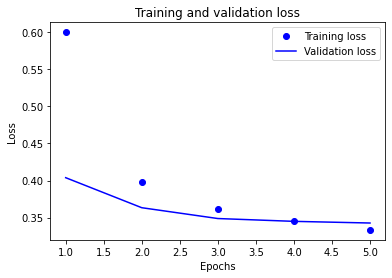

In [1447]:
import matplotlib.pyplot as plt

acc=history_dict['accuracy']
val_acc=history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

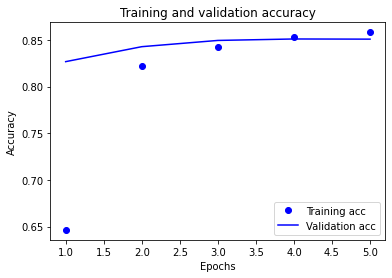

In [1448]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [1449]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [1450]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/practice/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [1451]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['최고']
vector

array([-0.15742376, -0.12942094, -0.16431135,  0.11319396, -0.11210472,
        0.11279696,  0.0825785 , -0.20411709, -0.11737934,  0.15198947,
       -0.16734155, -0.12158643, -0.14226523,  0.12688555,  0.1305208 ,
        0.02189706, -0.17216977,  0.16603643, -0.03943763, -0.12602556,
        0.15831   ,  0.14548917, -0.13637745,  0.09685455, -0.12179127,
        0.09557119,  0.15081762,  0.10819469,  0.16131446,  0.17311257,
        0.00159982,  0.13418733], dtype=float32)

In [1452]:
word_vectors.similar_by_word("최고")

[('여운', 0.9587080478668213),
 ('수작', 0.9503226280212402),
 ('먹먹', 0.949605405330658),
 ('10', 0.9473637938499451),
 ('이제서야', 0.9470676183700562),
 ('소장', 0.945749819278717),
 ('슬퍼요', 0.942376434803009),
 ('빠져들', 0.9411198496818542),
 ('탄탄', 0.9410998225212097),
 ('이제야', 0.9401180744171143)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [1453]:
import gensim.models.keyedvectors as word2vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.vec'
word2vec = word2vec.KeyedVectors.load_word2vec_format(word2vec_path, binary=False)

In [1454]:
word2vec.similar_by_word("최고")

[('손꼽히', 0.4780629873275757),
 ('책임자', 0.45002973079681396),
 ('경영자', 0.44841131567955017),
 ('최상급', 0.4441218972206116),
 ('자랑', 0.4403001666069031),
 ('끌어올리', 0.4225207567214966),
 ('올라서', 0.4208473265171051),
 ('꼽히', 0.4160469174385071),
 ('버금가', 0.4138873219490051),
 ('최저', 0.4119304418563843)]

In [1455]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [1456]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 3s 11ms/step - loss: 0.3234 - accuracy: 0.8646 - val_loss: 0.3421 - val_accuracy: 0.8520
Epoch 2/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3124 - accuracy: 0.8683 - val_loss: 0.3405 - val_accuracy: 0.8523
Epoch 3/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3099 - accuracy: 0.8694 - val_loss: 0.3388 - val_accuracy: 0.8540
Epoch 4/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3052 - accuracy: 0.8731 - val_loss: 0.3389 - val_accuracy: 0.8533
Epoch 5/5
188/188 [==============================] - 2s 10ms/step - loss: 0.3001 - accuracy: 0.8751 - val_loss: 0.3396 - val_accuracy: 0.8531


In [1457]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3491 - accuracy: 0.8506
[0.3490792214870453, 0.8506418466567993]


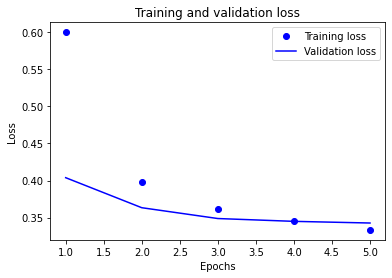

In [1458]:
acc=history_dict['accuracy']
val_acc=history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs=range(1,len(acc)+1)

plt.clf()   # 그림을 초기화합니다
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

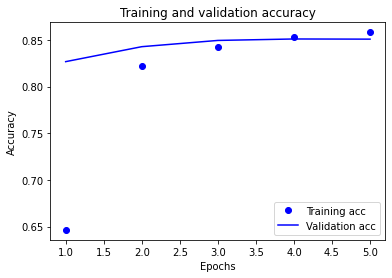

In [1459]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고
### - 계속 ko.bin을 읽는 과정에서  'utf-8' codec can't decode byte 0xc8 in position 0: invalid continuation byte라는 오류가 발생. 인코딩방법을 달리해도 계속 오류가 발생하길래 자료에 문제가 있는줄 알고 다시 다운 받고 해봤지만 계속 오류 발생. 결국 ko.bin이 아닌 ko.vec파일을 이용하니깐 오류 해결되었다.

### - RNN모델의 LSTM을 사용했을 때 정확도가 0.8156가 나왔다.
### - RNN모델의 GRU를 사용했을 때 정확도가 0.8180가 나왔다.
### - 1DConv 모델을 사용했을 때 정확도가 0.7992가 나왔다.
### - GlobalMaxPooling1D 모델을 사용했을 때 정확도가 0.8054가 나왔다.
- 정확도가 계속 85%가 안넘어서 epoch를 20에서 10으로 고치니깐 GlobalMaxPooling1D의 정확도가 조금 더 올라간 0.8218이 나왔다.epoch를 5, 10으로 고치니깐 0.8279 나왔다. 하지만 85%는 넘지 않았다.
- 제일 정확도가 높았던 LSTM모델의 epoch를 5, 10으로 고치니깐 0.8320이 나왔다. 조금 올랐다.
- 임베딩 벡터 차원수를 16에서 32로 고치니깐 0.8395로 조금 더 올랐다.
- LSTM모델의 벡터의 차원의 수를 8개에서 16개로 고치니깐 0.8258로 오히려 떨어졌다.
- dropout 0.5를 추가 하니깐 정확도가 0.8455로 늘어났다

### - RNN모델의 LSTM을 사용하고, dropout 0.7을 추가하니깐 정확도가 85%이상으로 나왔다.
### - 학습된 임베딩 모델로 '최고'와 비슷한 단어들을 찾았을 때 '여운, 수작, 먹먹, 10, 이제서야, 소장, 슬퍼요, 빠져들, 탄탄, 이제서야' 등 영화리뷰라면 좋은 영화에 쓸 법한 단어들이 나왔지만 최고의 사전적인 의미와는 거리가 멀어보인다.
### - 한국어 Word2Vec 임베딩 모델로 '최고'와 비슷한 단어들을 찾았을 때는 '손꼽히, 책임자, 경영자, 최상급, 자랑, 끌어올리, 올라서, 꼽히, 버금가, 최저' 등 최저를 제외하고는 최고의 사전적인 의미와 비슷한 단어들이 나왔다.
### - 한국어 Word2Vec 임베딩 모델의 결과가 더 정확하게 나왔다고 느끼지만, 정확도를 봤을 때는 학습된 임베딩 모델의 경우 0.8488이고, 한국어 Word2Vec 임베딩 모델의 경우에는 0.8509으로 후자가 조금 더 높았다. 눈에 띄는 차이가 있지는 않았다.